In [54]:
library(ggplot2)
library(tidyverse)
library(janitor)
library(dplyr)
library(pROC)
library(caret)
library(nnet)

In [55]:
undersampling_data <- read.csv(file = "../data/undersampled_data.csv")
oversampling_data <- read.csv(file = "../data/oversampled_data.csv")
smote_data <- read.csv(file = "../data/smote_augmented_data_80_percent.csv")
cleaned_data <- read.csv(file = "../data/train_data.csv")

In [56]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)
  
  # # Hàm để phân loại BMI
  # categorize_bmi <- function(bmi) {
  #   if (bmi < 18.5) {
  #     return('Underweight')
  #   } else if (bmi >= 18.5 & bmi < 24.9) {
  #     return('Normal weight')
  #   } else if (bmi >= 25 & bmi < 29.9) {
  #     return('Overweight')
  #   } else if (bmi >= 30 & bmi < 34.9) {
  #     return('Obesity class 1')
  #   } else if (bmi >= 35 & bmi < 39.9) {
  #     return('Obesity class 2')
  #   } else {
  #     return('Obesity class 3')
  #   }
  # }
  
  # # Tạo cột mới bmi_category cho dataframe data
  # data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # # Chuyển đổi bmi_category thành factor với các levels cụ thể
  # data$bmi_category <- factor(data$bmi_category, levels = c('Underweight', 'Normal weight', 'Overweight', 'Obesity class 1', 'Obesity class 2', 'Obesity class 3'))
  

  # # Xóa các cột không cần thiết
  # data <- within(data, rm("bmi", "ment_hlth"))
  
  # # Chuyển đổi các biến không định lượng thành factor
  # quantitative_vars <- c("phys_hlth")

  # non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  # data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)

  # Chuyển đổi biến diabetes_012 thành 3 biến nhị phân
  data$is_diabetes <- as.numeric(data$diabetes_012 == 2)
  data$is_prediabetes <- as.numeric(data$diabetes_012 == 1)
  data$is_no_diabetes <- as.numeric(data$diabetes_012 == 0)

  # Sắp xếp lại cột
  other_cols <- setdiff(names(data), c("diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes"))
  data <- data[, c(other_cols, "diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes")]
  
  return(data)
}


set.seed(42) 

train_test_split <- function(data, train_ratio = 0.8) {
    train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
    train_data <- data[train_indices, ]
    test_data <- data[-train_indices, ]
    res <- list(
        train_data = train_data,
        test_data = test_data
    )
    return(res)
}


In [57]:
undersampling_data <- process_data(undersampling_data)
oversampling_data <- process_data(oversampling_data)
smote_data <- process_data(smote_data)
cleaned_data <- process_data(cleaned_data)


Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


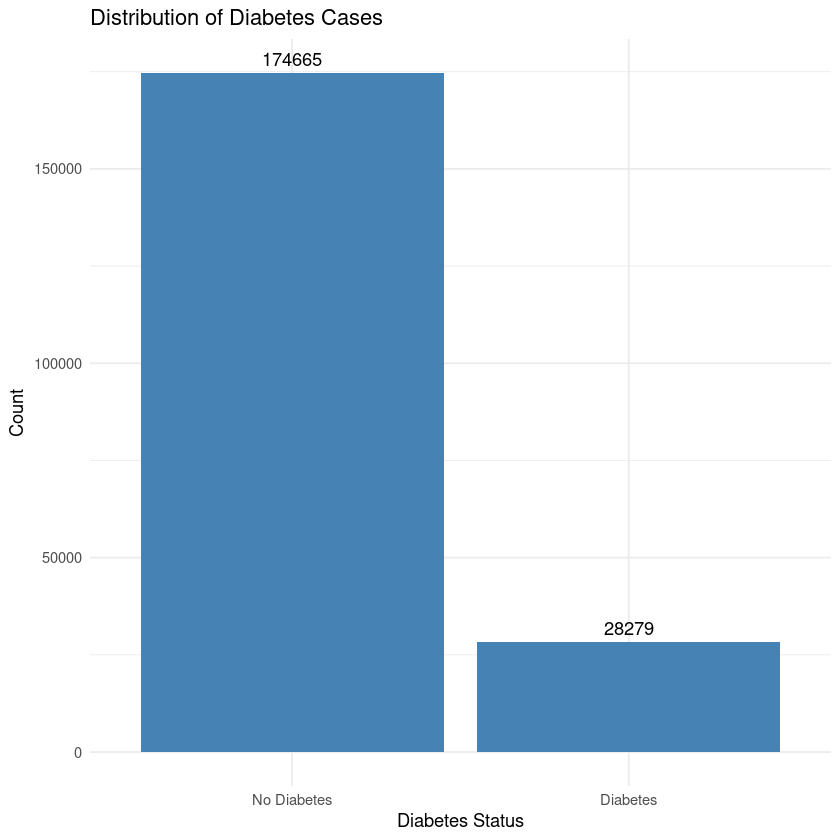

In [58]:
ggplot(cleaned_data, aes(x = factor(is_diabetes))) +
    geom_bar(fill = "steelblue") +
    geom_text(stat = 'count', aes(label = ..count..), vjust = -0.5) +
    labs(x = "Diabetes Status", y = "Count",
             title = "Distribution of Diabetes Cases") +
    scale_x_discrete(labels = c("No Diabetes", "Diabetes")) +
    theme_minimal()

In [59]:
library(ROSE)
set.seed(42)

# Use is_diabetes as the binary target variable
# Perform ROSE sampling
smote_balanced <- ROSE(is_prediabetes ~ ., data = cleaned_data, seed = 42, N = nrow(cleaned_data), p = 0.5)$data

# Print class distribution after ROSE
table(smote_balanced$is_prediabetes)


     0      1 
101624 101320 

In [60]:
# Undersampling
under_balanced <- ROSE(is_prediabetes ~ ., data = cleaned_data, seed = 42, 
                      N = 2 * sum(cleaned_data$is_prediabetes == 1), 
                      p = 0.5)$data

# Print class distribution after balancing
cat("Undersampling distribution:\n")
table(under_balanced$is_prediabetes)

# Oversampling
over_balanced <- ROSE(is_prediabetes ~ ., data = cleaned_data, seed = 42,
                     N = 2 * sum(cleaned_data$is_prediabetes == 0),
                     p = 0.5)$data


cat("\nOversampling distribution:\n")
table(over_balanced$is_prediabetes)

Undersampling distribution:



   0    1 
3652 3700 


Oversampling distribution:



     0      1 
199235 199301 

# Modeling

## Binary
### Đánh giá chung

In [61]:
# List of datasets to evaluate
datasets <- list(
    "Original Data" = cleaned_data,
    "Oversampled Data" = over_balanced,
    "Undersampled Data" = under_balanced,
    "SMOTE Data" = smote_balanced
)

# Store results
results <- data.frame(
    Dataset = character(),
    Accuracy = numeric(),
    Sensitivity = numeric(),
    Specificity = numeric(),
    stringsAsFactors = FALSE
)

# Loop through each dataset
for (dataset_name in names(datasets)) {
    data <- datasets[[dataset_name]]
    label = "is_prediabetes"
    
    # Split data
    train_data <- train_test_split(data)$train_data
    test_data <- train_test_split(data)$test_data
    
    # Define predictors
    predictors <- names(data)[!names(data) %in% 
                                   c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]
    
    # Create formula
    formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))
    
    # Fit model
    logistic_model <- glm(formula, data = train_data, family = "binomial")
    
    # Make predictions
    predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
    predictions <- ifelse(predictions_prob > 0.5, 1, 0)
    
    # Calculate metrics
    accuracy <- mean(predictions == test_data$is_prediabetes)
    sensitivity <- sum(predictions == 1 & test_data$is_prediabetes == 1) / sum(test_data$is_prediabetes == 1)
    specificity <- sum(predictions == 0 & test_data$is_prediabetes == 0) / sum(test_data$is_prediabetes == 0)
    
    # Store results
    results <- rbind(results, data.frame(
        Dataset = dataset_name,
        Accuracy = round(accuracy, 4),
        Sensitivity = round(sensitivity, 4),
        Specificity = round(specificity, 4)
    ))
}
# Display results
print(results)

            Dataset Accuracy Sensitivity Specificity
1     Original Data   0.9813      0.0000      1.0000
2  Oversampled Data   0.6394      0.6542      0.6247
3 Undersampled Data   0.6635      0.6733      0.6533
4        SMOTE Data   0.6378      0.6531      0.6226


### Lựa chọn bộ data SMOTE

In [62]:
data = smote_balanced
label = "is_prediabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob >  0.5, 1, 0)

accuracy <- mean(predictions == test_data$is_prediabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))

# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_prediabetes == 1) / sum(test_data$is_prediabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_prediabetes == 0) / sum(test_data$is_prediabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

# Calculate Kappa
conf_matrix <- table(Predicted = predictions, Actual = test_data$is_prediabetes)
cc <- sum(diag(conf_matrix))
sc <- sum(conf_matrix)
pp <- colSums(conf_matrix)
tt <- rowSums(conf_matrix)
kappa <- (cc * sc - sum(pp * tt)) / (sc^2 - sum(pp * tt))
print(paste("Kappa:", round(kappa, 4)))

# Calculate Macro F1
precision <- diag(conf_matrix) / colSums(conf_matrix)
recall <- diag(conf_matrix) / rowSums(conf_matrix)
macro_precision <- mean(precision)
macro_recall <- mean(recall)
macro_f1 <- 2 * macro_precision * macro_recall / (macro_precision + macro_recall)
print(paste("Macro F1:", round(macro_f1, 4)))

[1] "Model Accuracy: 0.6407"
[1] "Sensitivity: 0.6571"
[1] "Specificity: 0.6243"
[1] "Kappa: 0.2814"
[1] "Macro F1: 0.6408"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,12674
1,0,7627
0,1,6957
1,1,13331


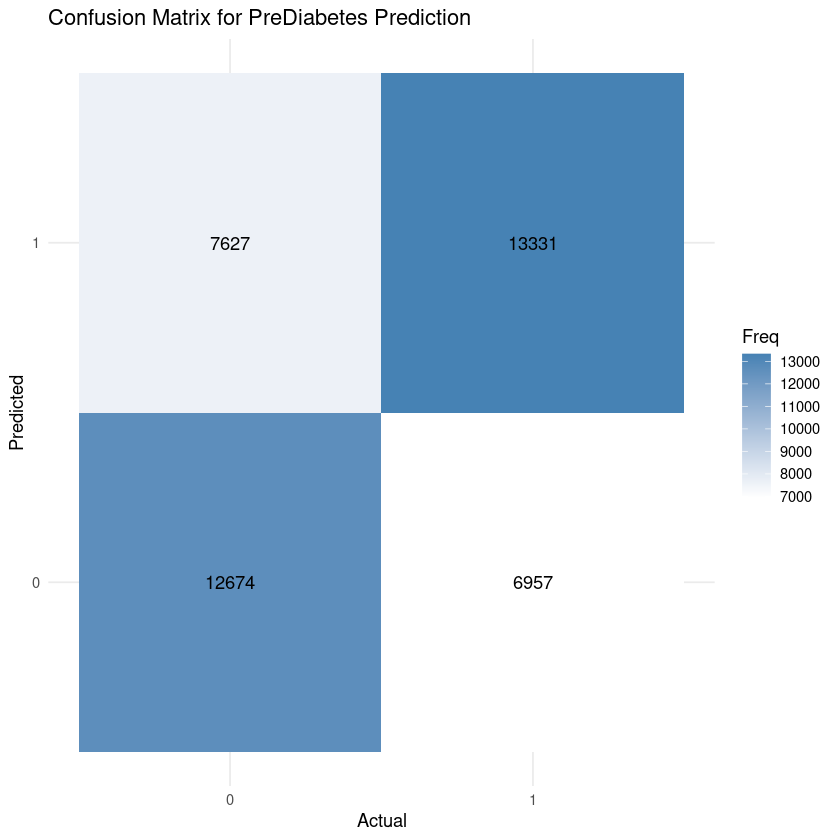

In [63]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_prediabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for PreDiabetes Prediction",
             x = "Actual",
             y = "Predicted")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.685-0.6953 (DeLong)


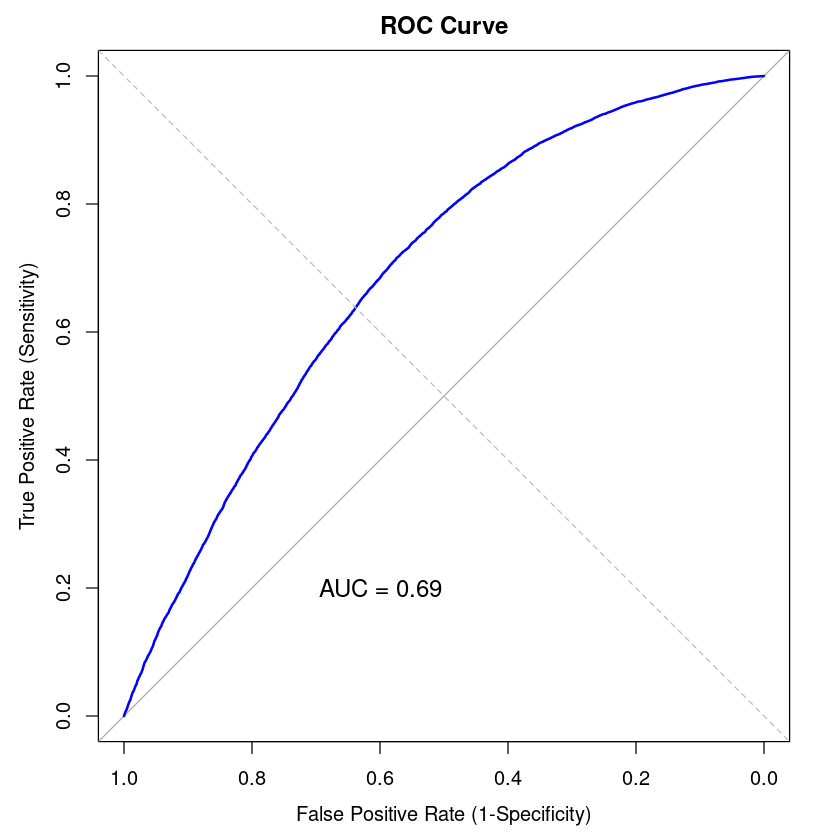

In [64]:
# Calculate ROC curve
roc_obj <- roc(test_data$is_prediabetes, predictions_prob)
auc_value <- auc(roc_obj)
print(ci.auc(roc_obj,conf.level = 0.95))

# Plot ROC curve
plot(roc_obj, main = "ROC Curve",
    col = "blue", lwd = 2,
    xlab = "False Positive Rate (1-Specificity)",
    ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# Add AUC value to plot
text(0.6, 0.2, paste("AUC =", round(auc_value, 3)),
    col = "black", cex = 1.2)

### Tìm ngưỡng tối ưu

In [65]:
# Lựa chọn ngưỡng tối ưu dựa trên phương pháp Youden Index
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "youden")
print(out_youd)

  threshold specificity sensitivity
1 0.4743353   0.5742574   0.7155461


In [66]:
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "closest.topleft")
print(out_youd)

  threshold specificity sensitivity
1 0.4956414   0.6157825   0.6678332


### Train lại với ngưỡng tối ưu

In [67]:
data = smote_balanced
label = "is_prediabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob >  0.452336, 1, 0)

accuracy <- mean(predictions == test_data$is_prediabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))
# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_prediabetes == 1) / sum(test_data$is_prediabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_prediabetes == 0) / sum(test_data$is_prediabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

[1] "Model Accuracy: 0.6449"
[1] "Sensitivity: 0.7583"
[1] "Specificity: 0.5321"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,10827
1,0,9520
0,1,4892
1,1,15350


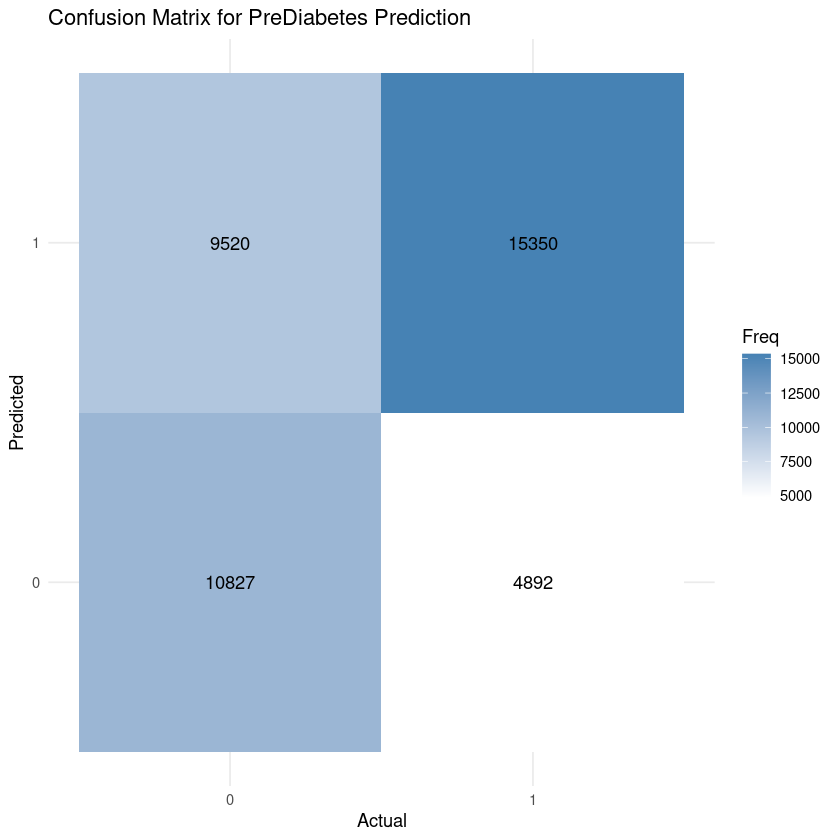

In [68]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_prediabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for PreDiabetes Prediction",
             x = "Actual",
             y = "Predicted")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.6856-0.6958 (DeLong)


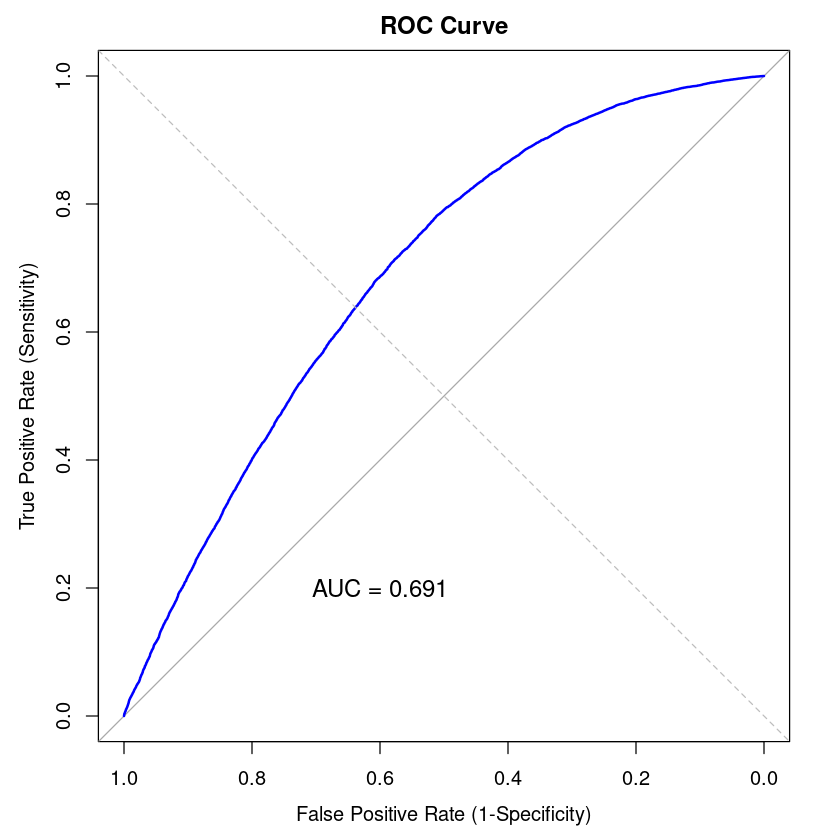

In [69]:
# Calculate ROC curve
roc_obj <- roc(test_data$is_prediabetes, predictions_prob)
auc_value <- auc(roc_obj)
print(ci.auc(roc_obj,conf.level = 0.95))

# Plot ROC curve
plot(roc_obj, main = "ROC Curve",
    col = "blue", lwd = 2,
    xlab = "False Positive Rate (1-Specificity)",
    ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# Add AUC value to plot
text(0.6, 0.2, paste("AUC =", round(auc_value, 3)),
    col = "black", cex = 1.2)

### Lựa chọn Undersampling Data

In [70]:
data = under_balanced
label = "is_prediabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob >  0.4807887, 1, 0)

accuracy <- mean(predictions == test_data$is_prediabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))

# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_prediabetes == 1) / sum(test_data$is_prediabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_prediabetes == 0) / sum(test_data$is_prediabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

# Calculate Kappa
conf_matrix <- table(Predicted = predictions, Actual = test_data$is_prediabetes)
cc <- sum(diag(conf_matrix))
sc <- sum(conf_matrix)
pp <- colSums(conf_matrix)
tt <- rowSums(conf_matrix)
kappa <- (cc * sc - sum(pp * tt)) / (sc^2 - sum(pp * tt))
print(paste("Kappa:", round(kappa, 4)))

# Calculate Macro F1
precision <- diag(conf_matrix) / colSums(conf_matrix)
recall <- diag(conf_matrix) / rowSums(conf_matrix)
macro_precision <- mean(precision)
macro_recall <- mean(recall)
macro_f1 <- 2 * macro_precision * macro_recall / (macro_precision + macro_recall)
print(paste("Macro F1:", round(macro_f1, 4)))

[1] "Model Accuracy: 0.6621"
[1] "Sensitivity: 0.6925"
[1] "Specificity: 0.6307"
[1] "Kappa: 0.3235"
[1] "Macro F1: 0.662"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,456
1,0,267
0,1,230
1,1,518


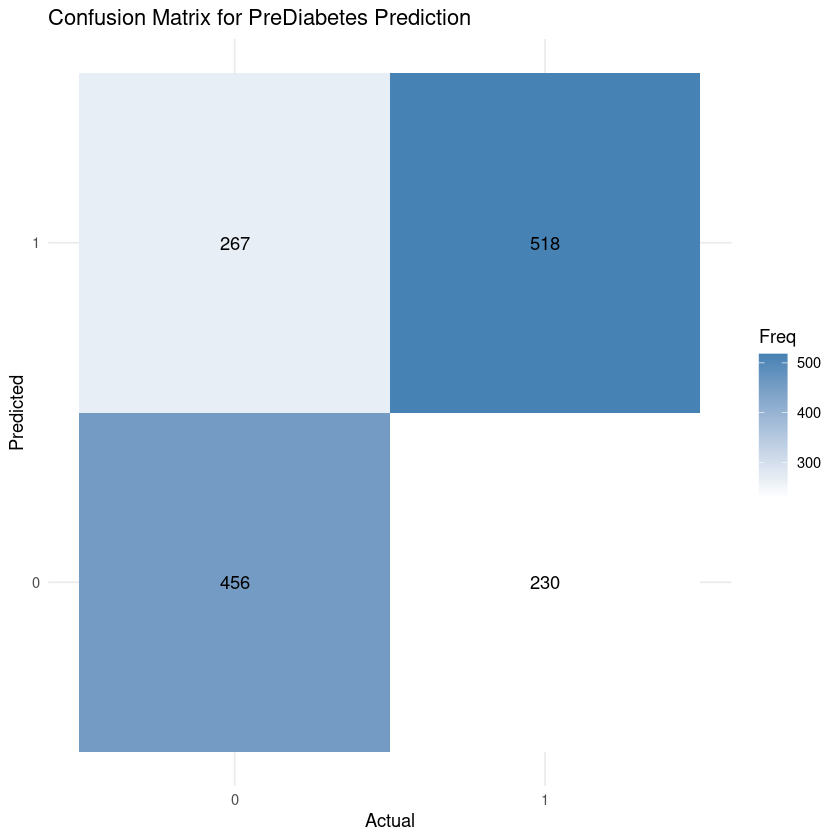

In [71]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_prediabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for PreDiabetes Prediction",
             x = "Actual",
             y = "Predicted")

### Lụa chọn Oversampling Data

In [72]:
data = over_balanced
label = "is_prediabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob >   0.4644232, 1, 0)

accuracy <- mean(predictions == test_data$is_prediabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))

# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_prediabetes == 1) / sum(test_data$is_prediabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_prediabetes == 0) / sum(test_data$is_prediabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

# Calculate Kappa
conf_matrix <- table(Predicted = predictions, Actual = test_data$is_prediabetes)
cc <- sum(diag(conf_matrix))
sc <- sum(conf_matrix)
pp <- colSums(conf_matrix)
tt <- rowSums(conf_matrix)
kappa <- (cc * sc - sum(pp * tt)) / (sc^2 - sum(pp * tt))
print(paste("Kappa:", round(kappa, 4)))

# Calculate Macro F1
precision <- diag(conf_matrix) / colSums(conf_matrix)
recall <- diag(conf_matrix) / rowSums(conf_matrix)
macro_precision <- mean(precision)
macro_recall <- mean(recall)
macro_f1 <- 2 * macro_precision * macro_recall / (macro_precision + macro_recall)
print(paste("Macro F1:", round(macro_f1, 4)))

[1] "Model Accuracy: 0.6453"
[1] "Sensitivity: 0.7316"
[1] "Specificity: 0.5582"


Warning message in cc * sc:
“NAs produced by integer overflow”


[1] "Kappa: NA"
[1] "Macro F1: 0.6471"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,22134
1,0,17521
0,1,10752
1,1,29301


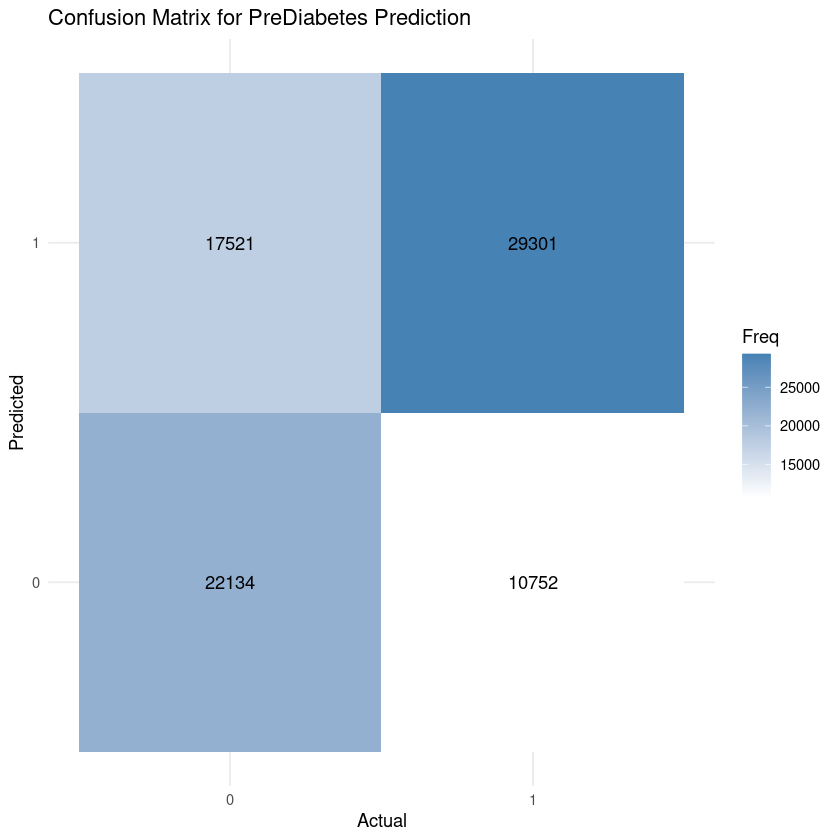

In [73]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_prediabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for PreDiabetes Prediction",
             x = "Actual",
             y = "Predicted")

## Multiclass

In [74]:
data = undersampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)

# weights:  66 (42 variable)
initial  value 9691.957611 
iter  10 value 8748.080038
iter  20 value 8601.584586
iter  30 value 8477.973819
iter  40 value 8384.504918
final  value 8373.851026 
converged


$Precision
        0         1         2 
0.5929095 0.4090909 0.5036765 

$Recall
        0         1         2 
0.6518817 0.3305085 0.5450928 

$Accuracy
[1] 0.5122393

$Kappa
[1] 0.266848

$Macro_F1
[1] 0.5055005



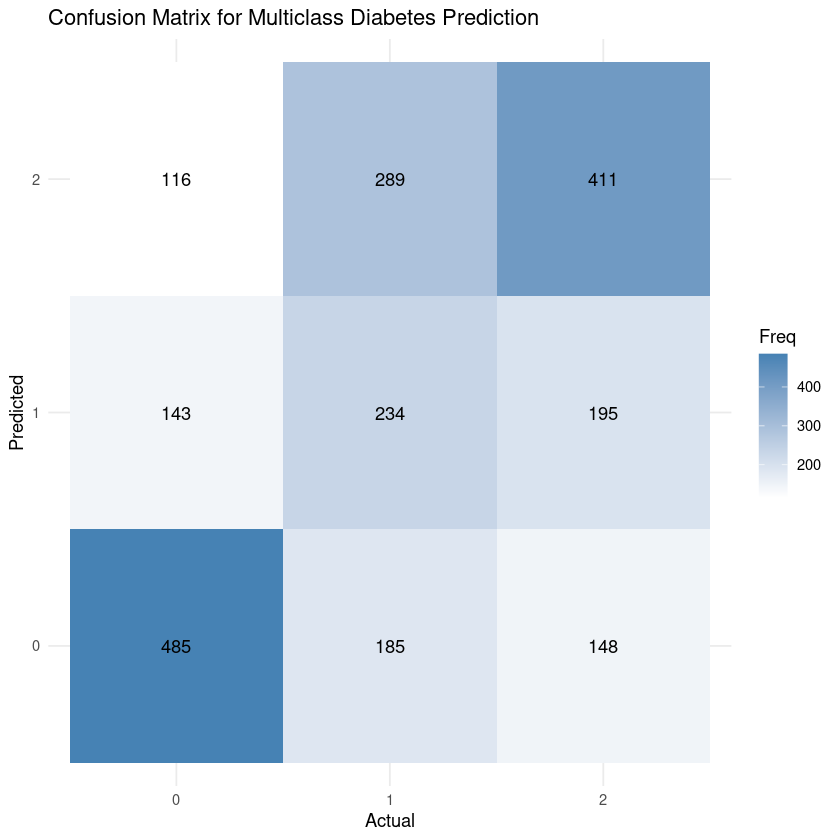

In [75]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted = predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")

In [76]:
data = oversampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
summary(logistic_model)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)


# weights:  66 (42 variable)
initial  value 390728.052139 
iter  10 value 355327.426992
iter  20 value 350086.315524
iter  30 value 349666.656448
iter  40 value 335877.962246
final  value 334614.768352 
converged


Call:
multinom(formula = formula, data = train_data, maxit = 1500)

Coefficients:
  (Intercept)   high_bp high_chol chol_check      smoker     stroke
1   -3.517804 0.3774184 0.6017865  0.8606918 -0.03448179 -0.1304998
2   -6.054955 0.7330739 0.6131570  1.3544333 -0.02206233  0.1197863
  heart_diseaseor_attack phys_activity       fruits     veggies
1            0.005698723   -0.01123705 -0.002971621 -0.04911556
2            0.251738136   -0.05683092 -0.042743539 -0.02653193
  hvy_alcohol_consump any_healthcare no_docbc_cost  gen_hlth   diff_walk
1          -0.1013122    -0.08268513     0.3437926 0.3371093 -0.09804167
2          -0.7830076     0.12132703     0.1159855 0.5673995  0.03201651
         sex       age   education      income bmi_category phys_category
1 0.08768276 0.1377921 -0.08504390 -0.08239211    0.3619560    0.02355493
2 0.24439077 0.1599218 -0.03628498 -0.06930196    0.4718257   -0.02103219

Std. Errors:
  (Intercept)     high_bp   high_chol chol_check      smoker     st

Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.6101658 0.4263000 0.4888244 

$Recall
        0         1         2 
0.7277904 0.2487177 0.5760374 

$Accuracy
[1] 0.5332846

$Kappa
[1] NA

$Macro_F1
[1] 0.5129324



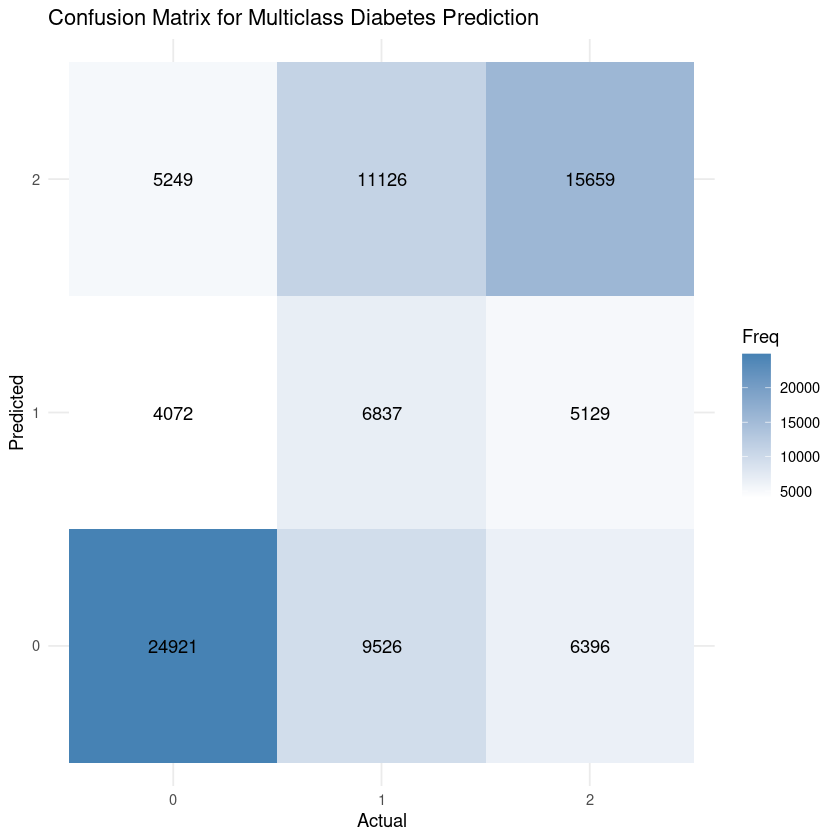

In [77]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted=predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")


# weights:  66 (42 variable)
initial  value 390728.052139 
iter  10 value 351192.649082
iter  20 value 347423.840672
iter  30 value 347001.080876
iter  40 value 335087.704822
final  value 331079.679653 
converged


Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.7344527 0.2559782 0.5647244 

$Recall
        0         1         2 
0.6077800 0.4238279 0.4963238 

$Accuracy
[1] 0.534578

$Kappa
[1] NA

$Macro_F1
[1] 0.5138078



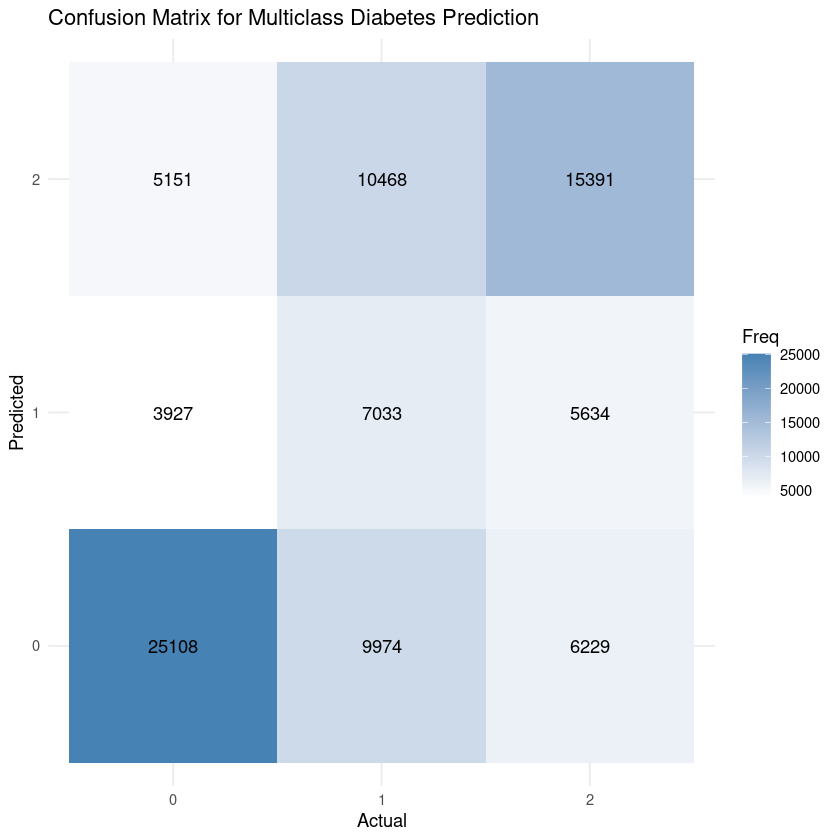

In [78]:
data = smote_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)

# Define evaluation function
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")
